In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from ema_workbench import (Policy, MultiprocessingEvaluator, save_results, load_results)

from ema_workbench.analysis import parcoords, prim

from problem_formulation import get_model_for_problem_formulation

In [3]:
pareto_policies = pd.read_csv('data/Pareto_Optimal_Results.csv')
dike_model, steps = get_model_for_problem_formulation(2)

In [63]:
pareto_policies.columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths',
       'Unnamed: 0', 'All Costs'],
      dtype='object')

In [5]:
def create_policy_list():
    policy_list = []
    for i, policy in pareto_policies.iterrows():
        policy_dictionary = policy.to_dict()
        name = f"policy_{i}"
        policy_list.append(Policy(name = name, **policy_dictionary))
    return policy_list

In [19]:
policies = create_policy_list()

In [ ]:
n_scenarios = 1000

with MultiprocessingEvaluator(dike_model) as evaluator: 
    results = evaluator.perform_experiments(scenarios = n_scenarios, policies = policies)

  0%|                                    | 221/93000 [00:44<4:29:12,  5.74it/s]

In [7]:
#save_results((results), 'data/PR_results.tar.gz')

In [9]:
#results = load_results('data/PR_results.tar.gz')

In [11]:
def signal_to_noise(data, x):
    mean = np.mean(data)
    std = np.std(data)
    return mean * std

In [15]:
experiments, outcomes = results

def ratios_policies():
    all_scores = {}
    for i in np.unique(experiments['policy']):
        scores = {}
        select_policy = experiments['policy'] == i
        for j in dike_model.outcomes:
            x = outcomes[j.name][select_policy]
            ratio = signal_to_noise(x, j.kind)
            scores[j.name] = ratio
            all_scores[i] = scores
            
    scores_df = pd.DataFrame.from_dict(all_scores).T
    return scores_df

NameError: name 'results' is not defined

In [17]:
scores = ratios_policies

NameError: name 'ratios_policies' is not defined

In [45]:
def plot_outcomes(data):
    limits = parcoords.get_limits(data)
    limits.loc[0, ['Expected Annual Damage', 'Expected Number of Deaths', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs']] = 0
    axes = parcoords.ParallelAxes(limits)
    axes.plot(data)
    plt.show()

In [47]:
plot_outcomes(scores)

NameError: name 'scores' is not defined

In [23]:
def filter_scores(n = 60):
    filtered_scores = scores.drop(scores['Expected Number of Deaths'].nlargest(n).index)
    print(len(filtered_scores))
    return filtered_scores

In [29]:
def select_filter_policies():
    filtered_policies = filter_scores().reset_index()
    filtered_policies = filtered_policies.iloc[:, 0]
    filtered_policies.tolist()
    return filtered_policies

In [31]:
filtered_policies = select_filter_policies()

NameError: name 'scores' is not defined

In [33]:
def calculate_regret(data, best):
    return np.abs(best - data)

In [35]:
experiments_for_regret, outcomes_for_regret = results

def find_best_outcome():
    all_regret = {}
    max_regret = {}
    for outcome in dike_model.outcomes:
        policy_column = experiments_for_regret['policy']
        data = pd.DataFrame({outcome.name: outcomes_for_regret[outcome.name], 'policy': experiments_for_regret['policy'], 'scenario': experiments_for_regret['scenario']}) 
        data.pivot(index = 'scenario', columns = 'policy')
        data.columns = data.columns.get_level_values(1)
        outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
        
        all_regret[outcome.name] = outcome_regret
        max_regret[outcome.name] = outcome_regret.max()

    return all_regret, max_regret

NameError: name 'results' is not defined

In [39]:
all_regret, max_regret = find_best_outcome()
all_regret = pd.DataFrame(all_regret)
max_regret = pd.DataFrame(max_regret)

NameError: name 'find_best_outcome' is not defined

In [49]:
plot_outcomes(max_regret)

NameError: name 'max_regret' is not defined

In [57]:
policy_regret = defaultdict(dict)
for key, value in all_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

NameError: name 'all_regret' is not defined

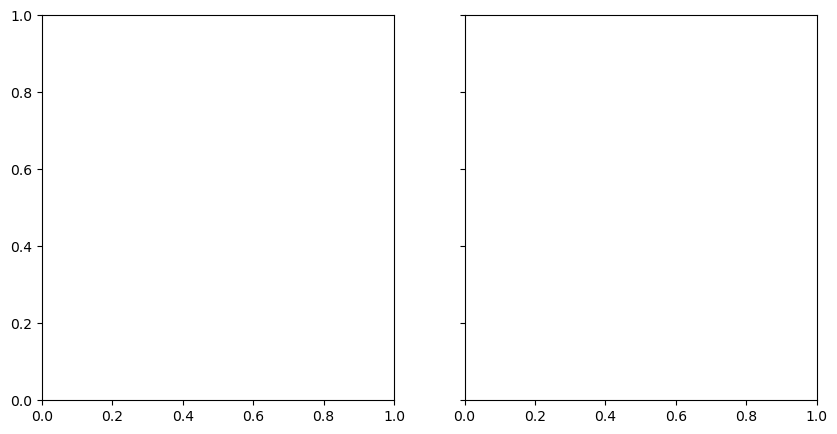

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5), 
                         sharey=True, sharex=True)

for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

In [65]:
x = experiments.iloc[:, :19] # Aanpassen
y = outcomes['Expected Number of Deaths']
a = y.quantile(0.85)
Y = (y > a).astype(int).values

prim_alg = prim.Prim(x, Y, threshold=0.5)
box1 = prim_alg.find_box()

NameError: name 'experiments' is not defined

In [67]:
box1.show_tradeoff()
plt.show()

NameError: name 'box1' is not defined

In [69]:
box1.inspect_tradeoff()

NameError: name 'box1' is not defined

In [71]:
#box.inspect(42)